In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pylab as py
py.rcParams['figure.figsize'] = (16, 6)
plt.hold(True)
plt.close()

from invenio_trends.etl.index_synchronizer import IndexSynchronizer
from invenio_trends.analysis.trends_detector import TrendsDetector
from invenio_trends.analysis.granularity import Granularity
from invenio_trends.utils import parse_iso_date

In [3]:
config = {
    'index': 'records-trends',
    'source_index': 'records-hep',
    'doc_type': 'hep',
    'analysis_field': 'abstracts.value',
    'date_field': 'earliest_date',
    'id_field': 'self_recid',
    'tokenizer': 'icu_tokenizer',
    'minimum_date': '2013-02-01',
    'maximum_date': None,
    'filter_script': "d = doc['earliest_date'].date; d.getDayOfYear() != 1",
    'unigram': True,
    'minimum_ngram': 2,
    'maximum_ngram': 3,
    'stopwords_file': '../invenio_trends/etl/stopwords.txt',
}

In [4]:
etl = IndexSynchronizer(config)

In [5]:
#etl.setup_index()
#etl.setup_analyzer()
#etl.setup_mappings()
#etl.synchronize()

In [4]:
td = TrendsDetector(config)

In [5]:
reference_date = parse_iso_date('2016-02-26T00:00:00.00')
gran = Granularity.day
foreground_window = 10
background_window = 365
minimum_frequency_threshold = 5
smoothing_len = 7
num_cluster = 3
num_trends = 1000

In [6]:
foreground_start = reference_date - foreground_window * gran.value
background_start = reference_date - background_window * gran.value
smoothing_window = np.ones(smoothing_len)

ids = td.interval_ids(foreground_start, reference_date)
all_terms = td.term_vectors(ids)
terms = td.sorting_freq_threshold(all_terms, minimum_frequency_threshold)
hists = td.terms_histograms(terms, background_start, reference_date, gran)
scores = td.hist_scores(hists, foreground_start, smoothing_window)
trending = td.classify_scores(scores, num_cluster)
trends = td.prune_scores(trending, num_trends)

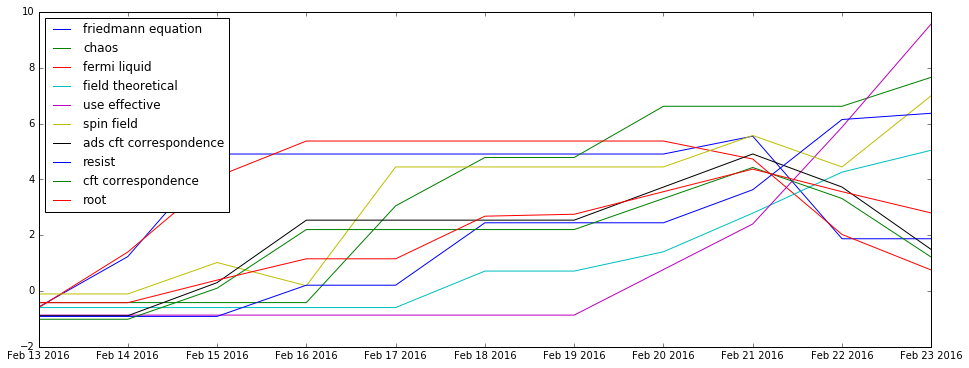

In [7]:
for term, stats, (date, score) in trends[:10]:
    plt.plot(date, score, label=term)
plt.legend(loc='upper left')
plt.show()